# Modeling Zinc modulation of NMDAR signaling

Modeling the dynamics of NMDAR-inhibition by Zinc binding.

The maximum conductance following a synaptic event is set by the following product: **a)** A conductance quantal setting the maximum conductance at full-activation level , **b)** a voltage-dependent term (Mg block), **c)** a Zn$^{2+}$-inhibition term set as $\big(1 - \alpha_{Zn} \, b_{Zn} \big)$ where $\alpha_{Zn}$ is the fraction of inhibited conductance at maximum binding level ($b_{Zn}$=1).

\begin{equation}
g^{max}_{NMDA}(V_m, b_{Zn}, t) = Q_{NMDA} \cdot N_{Mg}(V_m) \cdot \big(1 - \alpha_{Zn} \, b_{Zn} \big)
\end{equation}

How to model the time evolution of the bounded-Zn$^{2+}$ variable $b_{Zn}$ ? What is the best conceptual description ?

#### Two conceptually different models:

1. __The dynamics of bounded-Zn$^{2+}$ ($b_{Zn}$) is set by an underlying [Zn$^{2+}$] concentration variable ($c_{Zn}$).__
    
    There is an underlying Zinc concentration variable (cZn), each synaptic event increments this concentration variable and there is a decay over time of this quantity due to dilution/re-uptake. The "bounded-Zinc" (bZn) variable that modulates NMDAR signalling is a non-linear transformation of this variable, the effective binding is obtained thanks to a sigmoidal binding function. For intense synaptic activity the Zinc concentration can reach very high values and therefore the decay to go back to rest level will take longer than just the "decay time constant" of the concentration dynamics.

    The system of equation for such a model reads (Erf is the error function):
    
    
\begin{equation}
\left\{
\begin{split}
\tau_{Zn} \cdot \frac{d c_{Zn}}{ dt } & = - c_{Zn} + \delta c_{Zn} \sum_{\{t^{k}\}_{glut}} \delta (t-t^k) \\
b_{Zn} & = Erf( \frac{ c_{Zn} - c^0_{Zn}}{ \Delta c_{Zn}} )
\end{split}
\right.
\end{equation}

   
    
2. __The dynamics of bounded-Zn$^{2+}$ has no underlying variable and is a pure increment/decay dynamics.__
    
    The bounded-Zinc variable fully describes the phenomenon, without any other underlying dynamics, the temporal dynamics applies to that specific variable. At each synaptic event, Zinc is released and increments the effective-binding variable (bZn), each increment is followed by a decay to model the unbinding dynamics. Here, the on-linearity is model by a state-dependent (bZn-dependent) increment of the bounded-Zn variable (bZn), the higher bZn, the lower the increment (to produce the saturation up to 1).
    
    The system of equation for such a model reads:
    
\begin{equation}
\left\{
\begin{split}
\tau_{Zn} \cdot \frac{d b_{Zn}}{ dt } & = - b_{Zn} + I_{b_{Zn}}( b_{Zn} )  \sum_{\{t^{k}\}_{glut}} \delta (t-t^k) \\
I_{b_{Zn}} : b_{Zn} \rightarrow  & = I^0_{b_{Zn}} \cdot \big(1- b_{Zn} \big)
\end{split}
\right.
\end{equation}


In [8]:
from datavyz import graph_env_notebook as ge
import numpy as np

In [124]:
# all parameters in SI units ! (i.e. volts, amps, siemens, seconds, ...)

params = {
    # passive cellular properties
    'Cm':200e-12, # farad
    'gL':10e-9, # siemens
    'El':-70e-3, # volt
    # GABA
    'Trise_GABA':0.5e-3, # second
    'Tdecay_GABA':5e-3,
    'Q_GABA':1e-9,
    'Erev_GABA':-80e-3,
    # AMPA
    'Trise_AMPA':0.5e-3,
    'Tdecay_AMPA':5e-3,
    'Q_AMPA':1e-9,
    'Erev_AMPA':0e-3,
    # NMDA
    'NMDA-to-AMPA-ratio':0.8,
    'Trise_NMDA':7e-3,
    'Tdecay_NMDA':70e-3,
    'Q_NMDA':0.8e-9, # i.e. from 'NMDA-to-AMPA-ratio':0.8,
    'Erev_NMDA':0e-3,
    # Vm-modul NMDA
    'V0_NMDA':1./0.08,
    # Zn-modul NMDA - Model 1
    'Q_Zn':5e-9, # increment of effective Zn concentration
    'C0_Zn':10e-9,
    'deltaC_Zn':10e-9,
    # Zn-modul NMDA - Model 2
    'b0_Zn':0.3,
    'Trise_Zn':15e-3,
    'Tdecay_Zn':0.3,
    'alpha_Zn':0.4, # fraction of inactivated conductance at peak 
}

params_no_Zn = params.copy() 
params_no_Zn['Q_Zn'] = 0

In [125]:
import numpy as np
from scipy.special import erf

def inactivation_function(c, c0=0., dc=1.):
    """
    inactivation function derived from error function
    """
    return (erf((c-c0)/dc)+1.)/2.

def double_exponential(t, T1, T2):
    """
    double exponential function normalized to peak level
    """
    return (np.exp(-t/T2)-np.exp(-t/T1))/(T2/T1-1)*((T2/T1)**(T2/(T2-T1)))


def compute_time_variations_from_events(SET_OF_EVENTS,
                                        t,
                                        Trise=.1e-3, Tdecay=10e-3, quantal=1.):
    """
    integration of synaptic events to shape the synaptic conductance
    (convolution with double exponential over synaptic events)
    """
    conductance = 0*t # initialized to 0

    dt = t[1]-t[0]
    ilength = int(5*(Tdecay+Trise)/dt) # for each even we 
    event_waveform = quantal*double_exponential(t[:ilength]-t[0], Trise, Tdecay)
    
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event)**2) # find the time point where the event falls
        conductance[i0:min([i0+ilength,len(t)])] += event_waveform[:min([ilength,len(t)-i0])]
        
    return conductance


def compute_pre_from_events(SET_OF_EVENTS, t):
    conductance = 0*t # initialized to 0
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event)**2) # find the time point where the event falls
        conductance[i0] = 1
    return conductance


def voltage_dep_NMDA(x):
    return 1./(0.3+np.exp(-1e3*x*0.08))

def binding_increment(b, b0=0.4, db=.3):
    return b0*(1-b)

def solve_synapse_equation(t, params,
                           model='concentration-derived',
                           Glut_events=[],
                           alpha_Zn=0.4,
                           Vm=None):
         
    dt = t[1]-t[0]
    sim = {'t':t, 'model':model} # we store all results into a python dictionary
    pre_event_trace = compute_pre_from_events(Glut_events, t)
    sim['pre_event_trace'] = pre_event_trace

    if model=='concentration-derived':
        
        cZn = compute_time_variations_from_events(Glut_events, t,
                                Trise=1e-4, Tdecay=params['Tdecay_Zn'], quantal=params['Q_Zn'])
        bZn = inactivation_function(cZn,
                                    c0=params['C0_Zn'], dc=params['deltaC_Zn'])
        sim['cZn'] = cZn
        sim['bZn'] = bZn
        
    else:
        
        bZn = 0*t
        for i in range(len(t)-1):
            bZn[i+1] = bZn[i]*(1-dt/params['Tdecay_Zn'])
            bZn[i+1] += pre_event_trace[i+1]*binding_increment(bZn[i+1], b0=params['b0_Zn'])
        sim['cZn'] = None
        sim['bZn'] = bZn
   

    # NMDA before voltage-dependency and Zinc modulation
    gNMDA = compute_time_variations_from_events(Glut_events, t,
                    Trise=params['Trise_NMDA'], Tdecay=params['Tdecay_NMDA'], quantal=params['Q_NMDA'])
    
    # modulation function:    
    def NMDA_modulation(Vm, bZn, alpha_Zn=alpha_Zn):
        return voltage_dep_NMDA(Vm)*(1.-alpha_Zn*bZn)
    
    def Itot(Vm, gN, bZn):
        return params['gL']*(params['El']-Vm)+\
               NMDA_modulation(Vm,bZn)*gN*(params['Erev_NMDA']-Vm)
    
    sim['Vm'] = Vm
    sim['Itot'] = -Itot(Vm, gNMDA, sim['bZn']) # sign reversed (amplifier convention)
    sim['gNMDA'] = NMDA_modulation(Vm,sim['bZn'])*gNMDA

    return sim

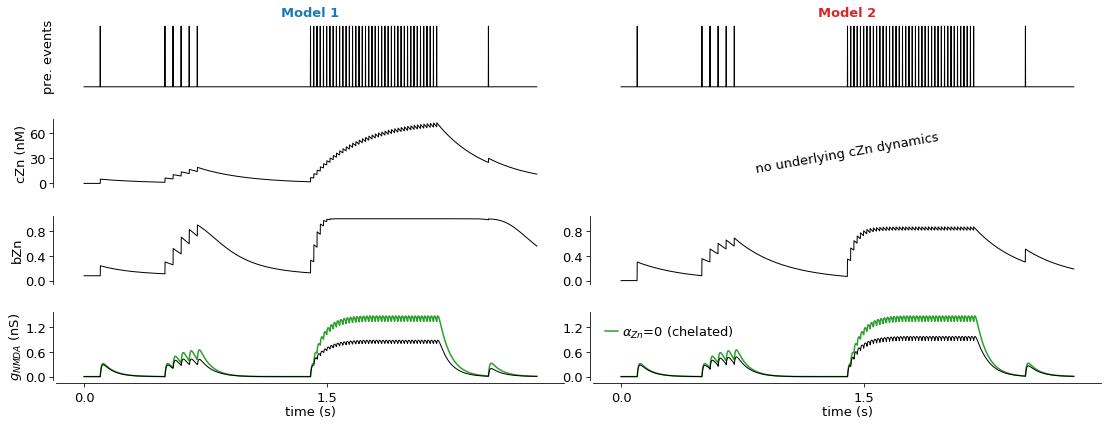

In [141]:
t = np.arange(2800)*1e-3
# same events in voltage-clamp -> hyperpolarized

EVENTS = [0.1, 0.5, 0.55, 0.6, 0.65, 0.7]+list(np.arange(40)*0.02+1.4)+[2.5]


sim0 = solve_synapse_equation(t, params, Glut_events=EVENTS, Vm=-10e-3, alpha_Zn=0.)
sim1 = solve_synapse_equation(t, params, Glut_events=EVENTS, Vm=-10e-3)
sim2 = solve_synapse_equation(t, params, Glut_events=EVENTS, Vm=-10e-3, model='')


fig, AX = ge.figure(axes=(4,2), figsize=(1.8,.6), wspace=.1, hspace=.7)

# model1
ge.title(AX[0][0], 'Model 1', color=ge.b, bold=True)
ge.plot(t, sim1['pre_event_trace'], ax=AX[0][0], axes_args={'spines':[], 'ylabel':'pre. events'})
ge.plot(t, 1e9*sim1['cZn'], ax=AX[1][0], axes_args={'spines':['left'], 'ylabel':'cZn (nM)'})
ge.plot(t, sim1['bZn'], ax=AX[2][0], axes_args={'spines':['left'], 'ylabel':'bZn', 'ylim':[-0.05,1.05]})
AX[3][0].plot(t, 1e9*sim0['gNMDA'],  color=ge.green, label='$\\alpha_{Zn}$=0 (chelated)')
ge.plot(t, 1e9*sim1['gNMDA'], ax=AX[3][0], axes_args={'xlabel':'time (s)', 'ylabel':'$g_{NMDA}$ (nS)'})


# model2
ge.title(AX[0][1], 'Model 2', color=ge.r, bold=True)
ge.plot(t, sim1['pre_event_trace'], ax=AX[0][1], axes_args={'spines':[]})
AX[1][1].axis('off')
ge.annotate(AX[1][1], 'no underlying cZn dynamics', (.5, .5), ha='center', va='center', rotation=10)
ge.plot(t, sim2['bZn'], ax=AX[2][1], axes_args={'spines':['left'], 'ylim':[-0.05,1.05]})
AX[3][1].plot(t, 1e9*sim0['gNMDA'],  color=ge.green, label='$\\alpha_{Zn}$=0 (chelated)')
ge.plot(t, 1e9*sim2['gNMDA'], ax=AX[3][1], axes_args={'xlabel':'time (s)'})
ge.legend(AX[3][1])
ge.save_on_desktop(fig, 'fig.png')